In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from google.colab import files
import io
import os

import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor, transforms

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])
# bigger size, more layers, more filters
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

# Data set
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Coral_files/training', transform=train_transform)
val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Coral_files/validation', transform=val_transform)
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Coral_files/testing', transform=val_transform)

# Data loader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

classes = [
    "Bleached corals",
    "Healthy corals"
]
#!unzip Testing.zip, note from teacher: create a csv of the file names??

""" To ensure that the dataset is labeling the images correctly -- it is!
def find_image_class(image_name, dataset):
    for idx in range(len(dataset.imgs)):
        path, label = dataset.imgs[idx]
        if os.path.basename(path) == image_name:
            return dataset.classes[label]
    return "Image not found in dataset"

# Example usage
image_name = "10033870215_3664757d59_o_0_1237.jpg"
image_class = find_image_class(image_name, train_dataset)
print(f"The image '{image_name}' belongs to the class: {image_class}")

"""

' To ensure that the dataset is labeling the images correctly -- it is!\ndef find_image_class(image_name, dataset):\n    for idx in range(len(dataset.imgs)):\n        path, label = dataset.imgs[idx]\n        if os.path.basename(path) == image_name:\n            return dataset.classes[label]\n    return "Image not found in dataset"\n\n# Example usage\nimage_name = "10033870215_3664757d59_o_0_1237.jpg"\nimage_class = find_image_class(image_name, train_dataset)\nprint(f"The image \'{image_name}\' belongs to the class: {image_class}")\n\n'

Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.int64
Minibatch 0
------------------------


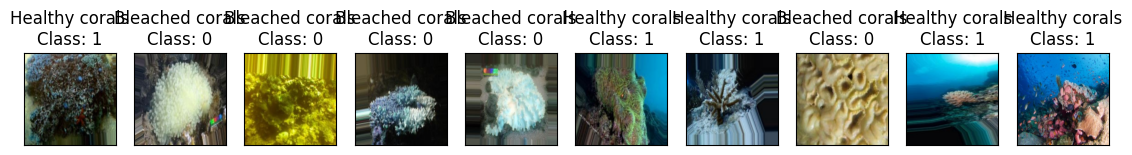



Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.int64
Minibatch 1
------------------------


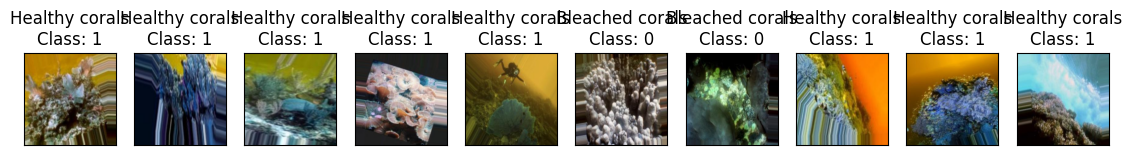



Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.int64
Minibatch 2
------------------------


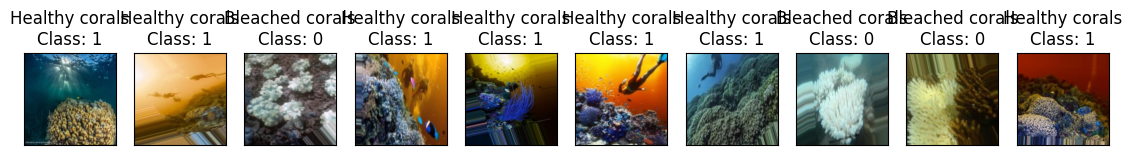



Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.int64
Minibatch 3
------------------------


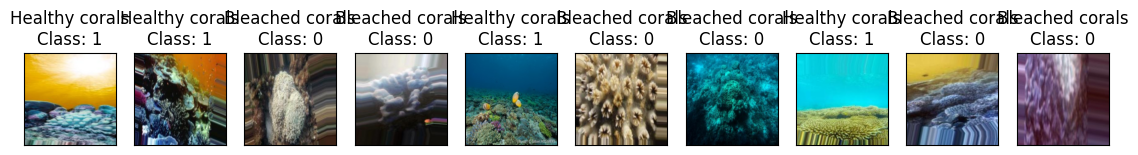



Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.int64
Minibatch 4
------------------------


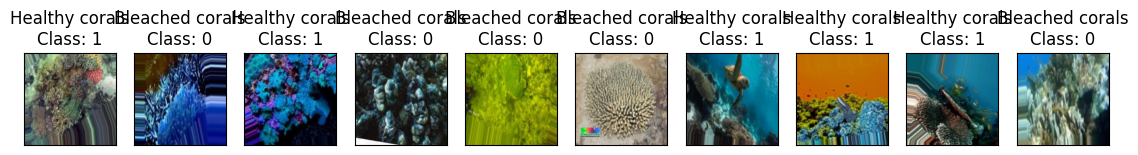



Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.int64
Minibatch 5
------------------------


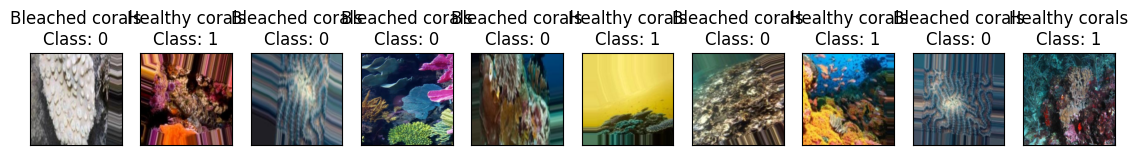



Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.int64
Minibatch 6
------------------------


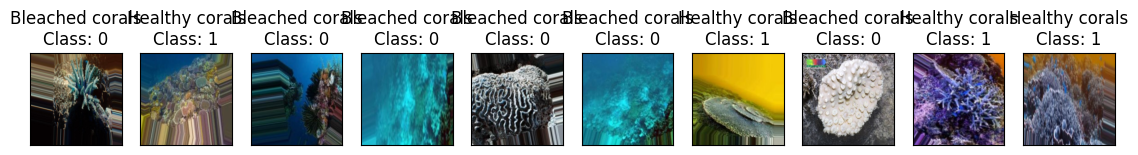



Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.int64
Minibatch 7
------------------------


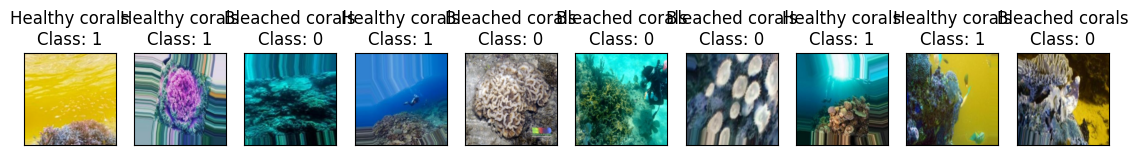



Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.int64
Minibatch 8
------------------------


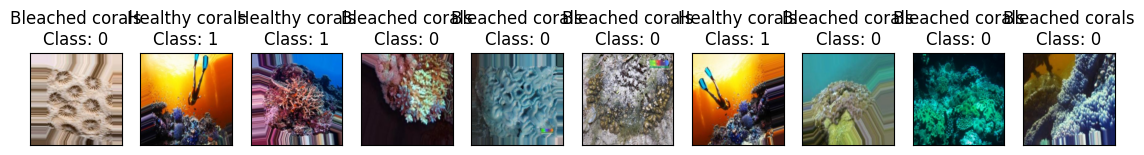



Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.int64
Minibatch 9
------------------------


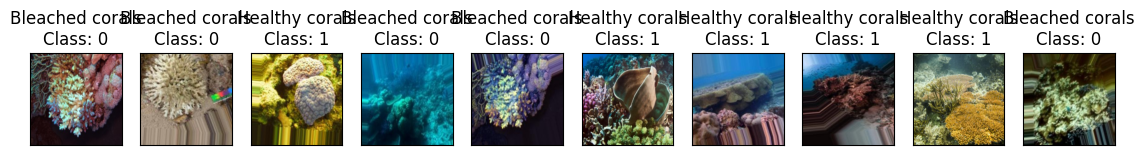



Shape of X [N, C, H, W]: torch.Size([64, 3, 224, 224])
Shape of y: torch.Size([64]) torch.int64
Minibatch 10
------------------------


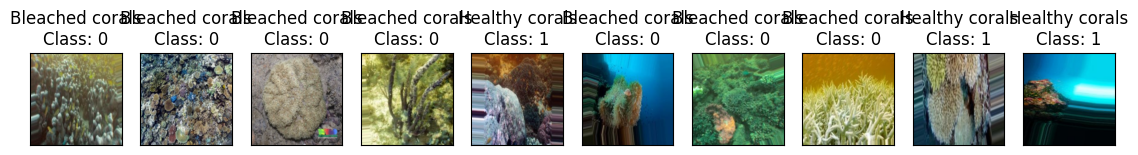

In [13]:
# look at the data
for i, batch in enumerate(train_loader):
    X,y = batch
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")

    fig, axs = plt.subplots(1, 10, figsize=(14,1.5))
    print('Minibatch {}'.format(i))
    print('------------------------')
    for j in range(10):
      image = X[j].permute(1, 2, 0).numpy() #change tensor shape from [C, H, W] to [H, W, C]
      axs[j].imshow(image)
      axs[j].set_title('{}\nClass: {}'.format(classes[y.numpy()[j]], y.numpy()[j]))
      axs[j].axes.xaxis.set_visible(False)
      axs[j].axes.yaxis.set_visible(False)
    plt.show()
    print()
    print()
    if i==10:
        break

In [ ]:
# The neural network to train the model
class CoralCNN(nn.Module):
  def __init__(self):
    super(CoralCNN, self).__init__()
    self.conv_stack = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(64),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),

      nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(256),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.fc1 = nn.Linear(50176, 512)
    self.dropout = nn.Dropout(p=0.5)
    self.fc2 = nn.Linear(512, 2)
    self.flatten = nn.Flatten()

  def forward(self, x):
    x = self.conv_stack(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = nn.ReLU()(x)
    x = self.dropout(x)
    x = self.fc2(x)
    return x

model = CoralCNN().to(device)

In [ ]:
!unzip Validation.zip
# csv of the files

unzip:  cannot find or open Validation.zip, Validation.zip.zip or Validation.zip.ZIP.


In [ ]:
#loss function and optimizers
loss_fn = nn.CrossEntropyLoss() #Could we use BCE loss instead cuz it's binary classification? There's no difference -- BCE = Binary Cross Entropy Loss

optimizer = optim.Adam(model.parameters(), lr=0.001,  weight_decay=1e-5)

In [14]:
def load_checkpoint(model, optimizer, latest_checkpoint_path):
    if os.path.isfile(latest_checkpoint_path):
        checkpoint = torch.load(latest_checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_train_loss = checkpoint['train_loss']
        print(f'Checkpoint loaded, resuming from epoch {start_epoch}')
        model_path = "/content/drive/MyDrive/Coral_files/coral_cnn_model.pth"
        torch.save(model.state_dict(), model_path)
        print(f"Model saved to {model_path}")

        return model, optimizer, start_epoch, best_train_loss
    else:
        print('No checkpoint found, starting from scratch')
        return model, optimizer, 0, float('inf')

In [15]:
interval_checkpoint_path = '/content/drive/MyDrive/checkpoints/latest_checkpoint.pth'

# Load checkpoint if exists
model, optimizer, start_epoch, best_train_loss = load_checkpoint(model, optimizer, interval_checkpoint_path)

Checkpoint loaded, resuming from epoch 29
Model saved to /content/drive/MyDrive/Coral_files/coral_cnn_model.pth


In [ ]:
def train(dataloader, model, loss_fn, optimizer, interval_checkpoint_path):
    model.train()
    size = len(dataloader.dataset)
    model.train()

    losses = []
    for step, (X, y) in enumerate(dataloader): #training loop
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 10 == 0:
            loss_, current = loss.item(), step * len(X)
            correct = (pred.argmax(1) == y).type(torch.float).sum().item() # accuracy
            print(f"Train Metrics: \n Accuracy: {(correct):>0.1f}%, loss: {loss_:>8f} \n")

            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': loss
            }, interval_checkpoint_path.format(epoch=epoch+1))
            print(f'Interval checkpoint saved at epoch {epoch+1}')
        losses.append(loss.item())
    return losses

In [ ]:
#Train for tracking losses

model, optimizer, start_epoch, best_train_loss = load_checkpoint(model, optimizer, interval_checkpoint_path)

epochs = 30
train_losses = []

for epoch in range(start_epoch, epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    epoch_train_losses = train(train_loader, model, loss_fn, optimizer, interval_checkpoint_path=interval_checkpoint_path)
    train_losses.extend(epoch_train_losses)


model.eval()
correct_val = 0
total_val = 0
val_loss = 0.0
with torch.no_grad():
    for batch in val_loader:
      batch_X, batch_y = batch
      batch_X, batch_y = batch_X.to(device), batch_y.to(device)

      outputs = model(batch_X)
      loss = loss_fn(outputs, batch_y)
      val_loss += loss.item()

      # Calculate validation accuracy
      _, predicted = torch.max(outputs.data, 1)
      total_val += batch_y.size(0)
      correct_val += (predicted == batch_y).sum().item()
val_loss /= len(val_loader)
val_accuracy = 100 * correct_val / total_val

print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

plt.plot(train_losses, label='Train')
plt.xlabel('Number of Steps')
plt.ylabel('Cross Entropy Loss')
plt.legend()
plt.show()


Checkpoint loaded, resuming from epoch 20
Epoch 21
-------------------------------
Train Metrics: 
 Accuracy: 62.0%, loss: 0.083323 

Interval checkpoint saved at epoch 21
Train Metrics: 
 Accuracy: 61.0%, loss: 0.435960 

Interval checkpoint saved at epoch 21
Train Metrics: 
 Accuracy: 60.0%, loss: 0.107873 

Interval checkpoint saved at epoch 21
Train Metrics: 
 Accuracy: 60.0%, loss: 0.173506 

Interval checkpoint saved at epoch 21
Train Metrics: 
 Accuracy: 61.0%, loss: 0.092541 

Interval checkpoint saved at epoch 21
Train Metrics: 
 Accuracy: 64.0%, loss: 0.020510 

Interval checkpoint saved at epoch 21
Train Metrics: 
 Accuracy: 62.0%, loss: 0.105794 

Interval checkpoint saved at epoch 21
Train Metrics: 
 Accuracy: 64.0%, loss: 0.033125 

Interval checkpoint saved at epoch 21
Train Metrics: 
 Accuracy: 64.0%, loss: 0.022858 

Interval checkpoint saved at epoch 21
Train Metrics: 
 Accuracy: 59.0%, loss: 0.143264 

Interval checkpoint saved at epoch 21
Train Metrics: 
 Accuracy: 

In [ ]:
#Test data Accuracy
model.eval()
correct_test = 0
total_test = 0
test_loss = 0.0
with torch.no_grad():
    for batch in test_loader:
        batch_X, batch_y = batch

        outputs = model(batch_X)
        loss = loss_fn(outputs, batch_y)
        test_loss += loss.item()

        # Calculate validation accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_test += batch_y.size(0)
        correct_test += (predicted == batch_y).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100 * correct_test / total_test
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

In [ ]:
#hyperparameter search for dropout rate and learning rate

#from torch.utils.data import Subset
#indices = list(range(500))
#train_dataset = Subset(train_dataset, indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

for dropout_rate in range(2, 7):
  for learning_rate in range(-2, -5, -1):
    print("Learning rate: " + str(10 ** learning_rate))
    print("Dropout rate: " + str(dropout_rate/10))
    class CoralCNN(nn.Module):
      def __init__(self):
        super(CoralCNN, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout(p=(dropout_rate/10)),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(802816, 32))
        self.flatten = nn.Flatten()

      def forward(self, x):
        a = self.conv_stack(x)
        a = self.flatten(a) #a = a.view(a.size(0), -1)
        logits = self.classifier(a)
        return logits

    model = CoralCNN().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr= (10 ** learning_rate))

    train_accuracies = []
    val_accuracies = []

    # Training and validation loop
    #Train for tracking losses
    epochs = 10
    train_losses = []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}\n-------------------------------")
        epoch_train_losses = train(train_loader, model, loss_fn, optimizer)
        train_losses.extend(epoch_train_losses)

    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
          batch_X, batch_y = batch
          batch_X, batch_y = batch_X.to(device), batch_y.to(device)

          outputs = model(batch_X)
          loss = loss_fn(outputs, batch_y)
          val_loss += loss.item()

          # Calculate validation accuracy
          _, predicted = torch.max(outputs.data, 1)
          total_val += batch_y.size(0)
          correct_val += (predicted == batch_y).sum().item()
    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val

    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    plt.plot(train_losses, label='Train')
    plt.xlabel('Number of Steps')
    plt.ylabel('Cross Entropy Loss')
    plt.legend()
    plt.show()

Learning rate: 0.01
Dropout rate: 0.2
Epoch 1
-------------------------------
Train Metrics: 
 Accuracy: 1.0%, loss: 4.278259 

Epoch 2
-------------------------------
Train Metrics: 
 Accuracy: 32.0%, loss: 0.000000 

Epoch 3
-------------------------------
Train Metrics: 
 Accuracy: 32.0%, loss: 0.000000 

Epoch 4
-------------------------------
Train Metrics: 
 Accuracy: 32.0%, loss: 0.000000 

Epoch 5
-------------------------------
Train Metrics: 
 Accuracy: 32.0%, loss: 0.000000 

Epoch 6
-------------------------------
Train Metrics: 
 Accuracy: 32.0%, loss: 0.000000 

Epoch 7
-------------------------------
Train Metrics: 
 Accuracy: 32.0%, loss: 0.000000 

Epoch 8
-------------------------------
Train Metrics: 
 Accuracy: 32.0%, loss: 0.000000 

Epoch 9
-------------------------------
Train Metrics: 
 Accuracy: 32.0%, loss: 0.000000 

Epoch 10
-------------------------------
Train Metrics: 
 Accuracy: 32.0%, loss: 0.000000 



In [ ]:
#hyperparameter search for optimizer

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

optims = [
    optim.Adadelta(model.parameters(), lr=(10 ** -3)),
    optim.Adam(model.parameters(), lr=(10 ** -3)),
    optim.AdamW(model.parameters(), lr=(10 ** -3)),
    optim.RMSprop(model.parameters(), lr=(10 ** -3)),
    optim.SGD(model.parameters(), lr=(10 ** -3))
]

for optim_num in range(len(optims)):
  class CoralCNN(nn.Module):
    def __init__(self):
      super(CoralCNN, self).__init__()
      self.conv_stack = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.Dropout(p=0.5),
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(64),
          nn.MaxPool2d(kernel_size=2, stride=2)
      )
      self.classifier = nn.Sequential(
          nn.Linear(802816, 32))
      self.flatten = nn.Flatten()

    def forward(self, x):
      a = self.conv_stack(x)
      a = self.flatten(a) #a = a.view(a.size(0), -1)
      logits = self.classifier(a)
      return logits

  model = CoralCNN().to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = optims[optim_num]

  train_accuracies = []
  val_accuracies = []

  # Training and validation loop
  #Train for tracking losses
  epochs = 10
  train_losses = []

  for epoch in range(epochs):
      print(f"Epoch {epoch+1}\n-------------------------------")
      epoch_train_losses = train(train_loader, model, loss_fn, optimizer)
      train_losses.extend(epoch_train_losses)

  model.eval()
  correct_val = 0
  total_val = 0
  val_loss = 0.0
  with torch.no_grad():
      for batch in val_loader:
        batch_X, batch_y = batch
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        outputs = model(batch_X)
        loss = loss_fn(outputs, batch_y)
        val_loss += loss.item()

        # Calculate validation accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_val += batch_y.size(0)
        correct_val += (predicted == batch_y).sum().item()
  val_loss /= len(val_loader)
  val_accuracy = 100 * correct_val / total_val

  print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

  plt.plot(train_losses, label='Train')
  plt.xlabel('Number of Steps')
  plt.ylabel('Cross Entropy Loss')
  plt.legend()
  plt.show()